From https://www.machinelearningplus.com/time-series/time-series-analysis-python/

# Time series analysis with Python

In [2]:
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams.update({'figure.figsize':(10,7),'figure.dpi':120})

Importing the dataframe to use:


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


Or better still, we can use the date as index of our data:


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


Visualize the data:

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x,y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show

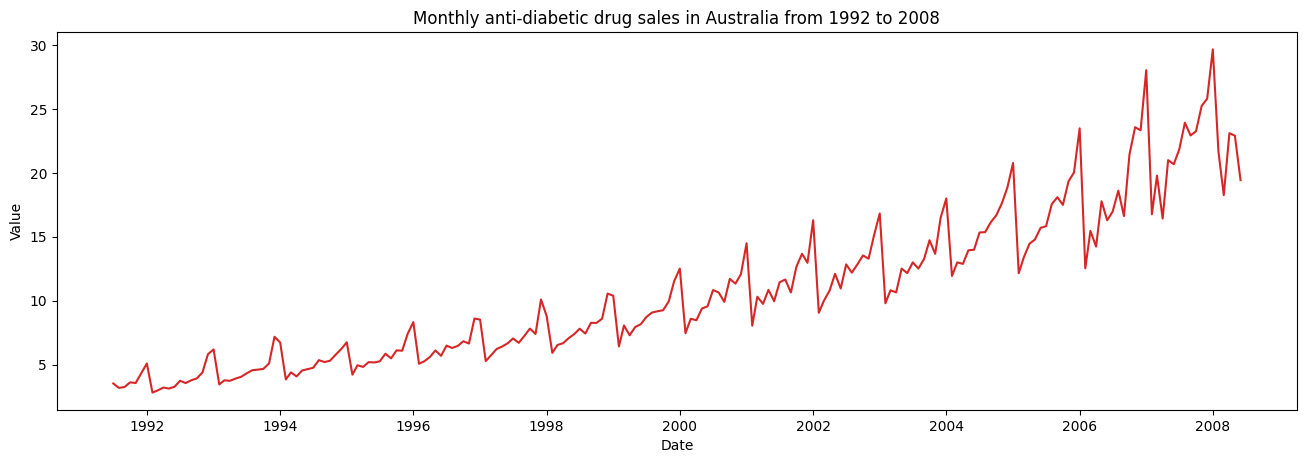

In [5]:
plot_df(df, df.index, df.value, title="Monthly anti-diabetic drug sales in Australia from 1992 to 2008")

Seasonal plots:


In [6]:
df.reset_index(inplace=True)
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [7]:
#prepare the data
df['year'] = df.date.apply(lambda x: x.year)
#df['month'] = df.date.apply(lambda x: x.month) #For numeric months
df['month'] = [d.strftime('%b') for d in df.date]
years = df.year.unique()

In [8]:
df

,date,value,year,month
0,1991-07-01,3.526591,1991,Jul
1,1991-08-01,3.180891,1991,Aug
2,1991-09-01,3.252221,1991,Sep
3,1991-10-01,3.611003,1991,Oct
4,1991-11-01,3.565869,1991,Nov
...,...,...,...,...
199,2008-02-01,21.654285,2008,Feb
200,2008-03-01,18.264945,2008,Mar
201,2008-04-01,23.107677,2008,Apr
202,2008-05-01,22.912510,2008,May


In [9]:
#Colors:
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

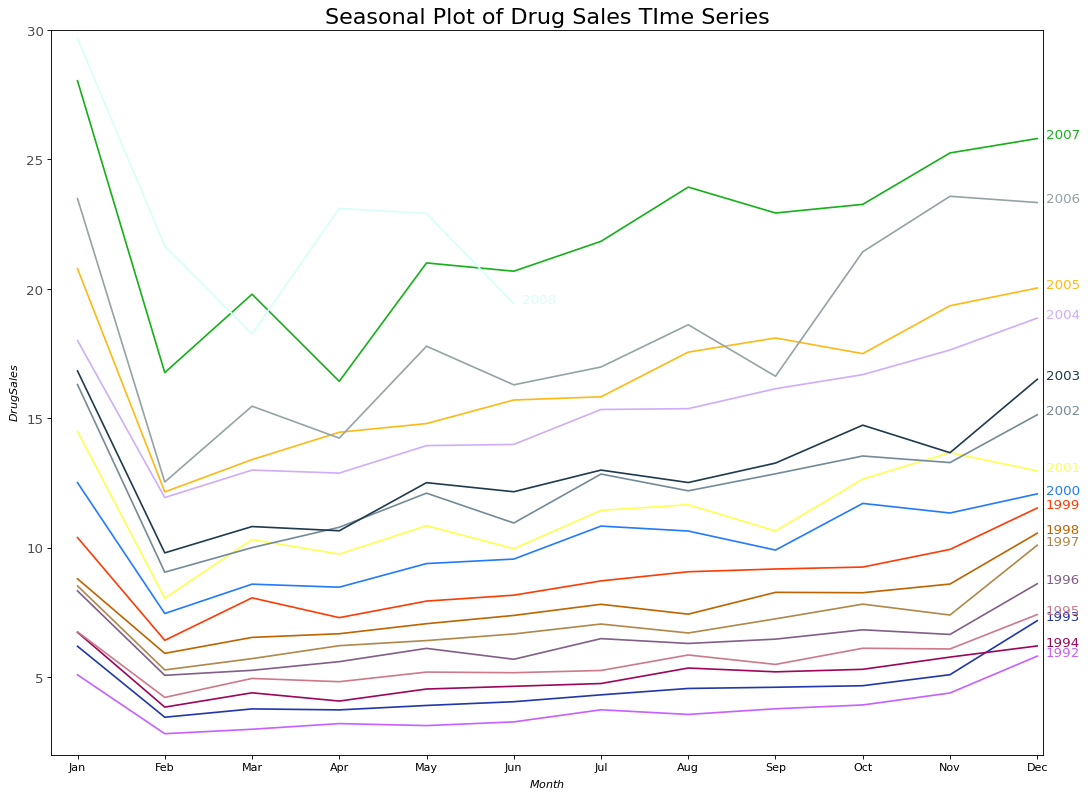

In [10]:
plt.figure(figsize=(16,12), dpi=80)
for i, e in enumerate(years):
    if i>0:
        plt.plot('month', 'value', data=df.loc[df.year==e, :], color = mycolors[i], label=e)
        plt.text(df.loc[df.year==e, :].shape[0]-0.9, df.loc[df.year==e, 'value'][-1:].values[0], e, fontsize=12, color=mycolors[i])

#Decoration:
plt.gca().set(xlim=(-0.3, 11.07), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title('Seasonal Plot of Drug Sales TIme Series', fontsize = 20)

plt.show()

Yearly and monthly box plots:

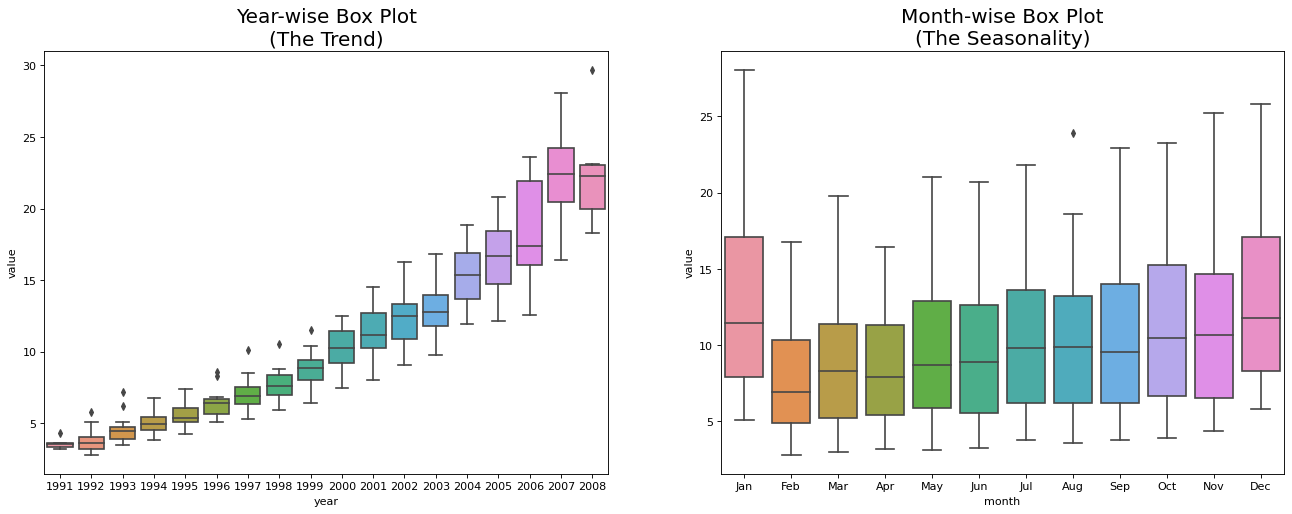

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7), dpi=80)
sns.boxplot(x='year', y='value', data=df, ax = axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :], ax = axes[1])

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Decompose and extract components from time series:

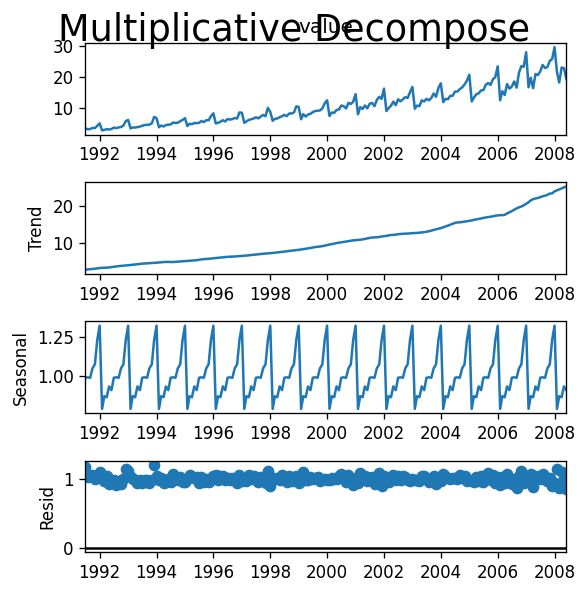

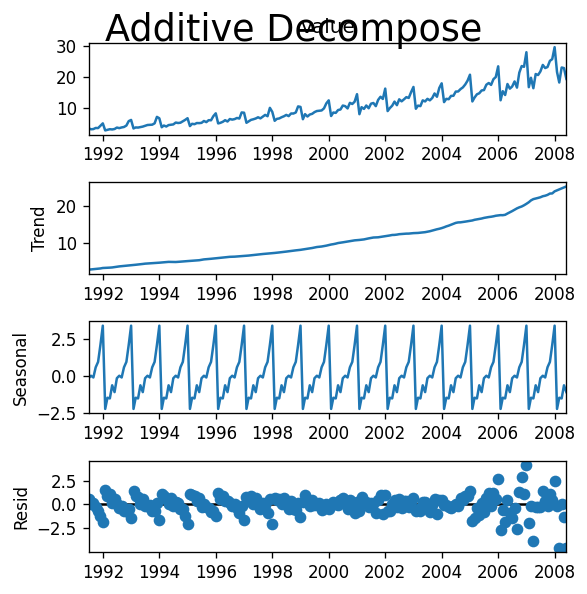

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (5,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()



In [16]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869


Check for stationarity using Augmented Dickey Fuller test (ADH Test) and Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test.

In [7]:
from statsmodels.tsa.stattools import adfuller, kpss
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])

# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.14518568930674
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476

KPSS Statistic: 1.313675
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/david/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/david/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
